In [120]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb

# Setting color palette and style
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [121]:
#Import data
df = pd.read_csv('NI_hourly.csv', parse_dates=True)

In [122]:
# Setting Datetime column as index
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)
df.head()

,NI_MW
Datetime,
2004-12-31 01:00:00,9810.0
2004-12-31 02:00:00,9001.0
2004-12-31 03:00:00,8509.0
2004-12-31 04:00:00,8278.0
2004-12-31 05:00:00,8089.0


<AxesSubplot:title={'center':'NI energy used in MW'}, xlabel='Datetime'>

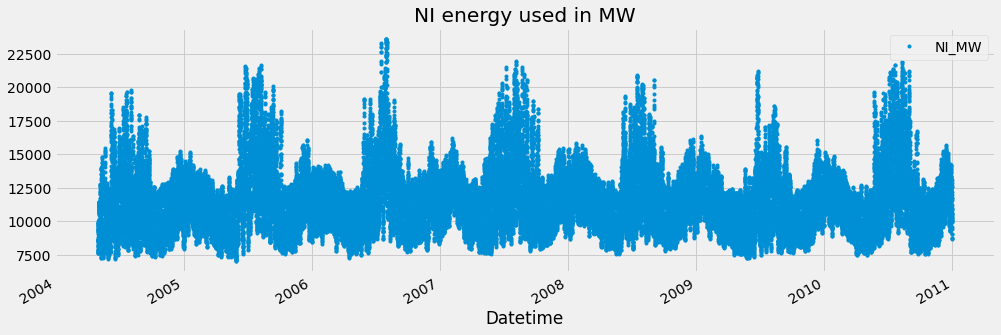

In [123]:
# Plotting energy used by Datetime
df.plot(style=".", figsize=(15, 5), color=color_pal[0], title="NI energy used in MW")

## Splitiing Data into Train and Test

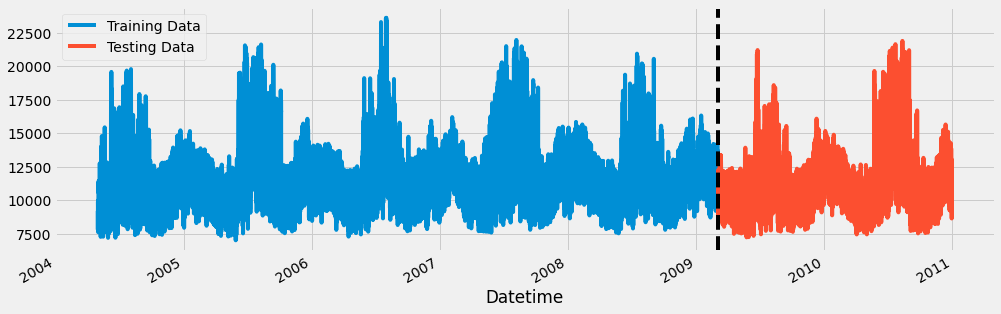

In [124]:
train = df.loc[df.index < '03-05-2009']
test = df.loc[df.index >= '03-05-2009']

# Visualizing training and testing data splitiing

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Data')
test.plot(ax=ax, label='Testing Data')
ax.legend(['Training Data', 'Testing Data'])
ax.axvline('03-05-2009', color='black', ls='--')

<AxesSubplot:title={'center':'Weekly Energy Usage'}, xlabel='Datetime'>

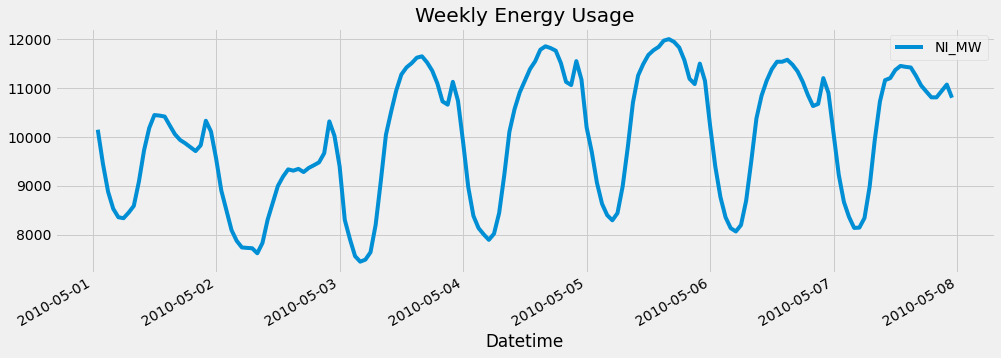

In [125]:
# Lets see energy use by random week
df.loc[(df.index > '2010-05-01') & (df.index < '2010-05-08')].plot(figsize=(15,5), title='Weekly Energy Usage')

1st May 2010 is Saturday. So we can see that we have low energy usage on weekends. 

In [126]:
# function to apply new columns 
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.day_of_week
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year
    df['dayofyear'] = df.index.day_of_year
    return df

In [127]:
df = create_features(df)

## Visualize Feature to Target Relashonship

Text(0.5, 1.0, 'MW by Hour')

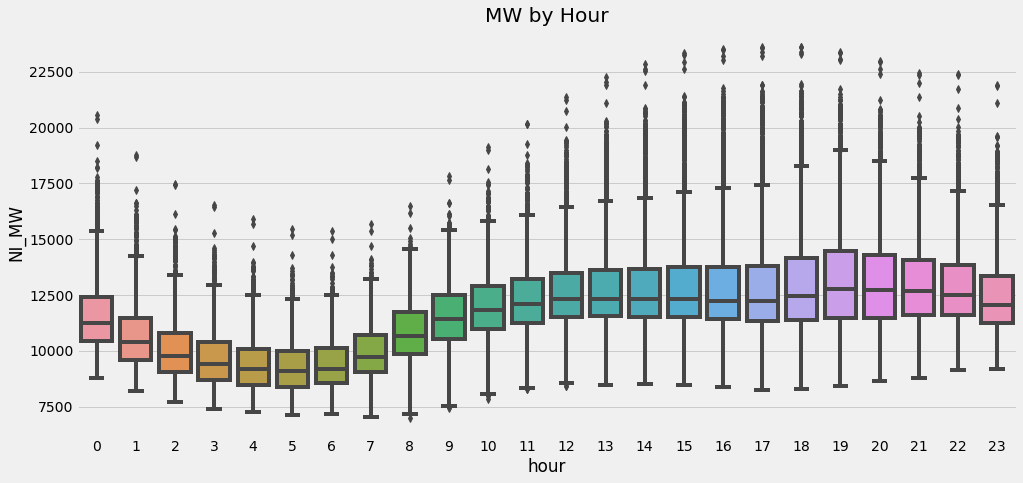

In [128]:
fig, ax = plt.subplots(figsize=(15,7))
sns.boxplot(data=df, x='hour', y='NI_MW')
ax.set_title('MW by Hour')

Text(0.5, 1.0, 'MW by Month')

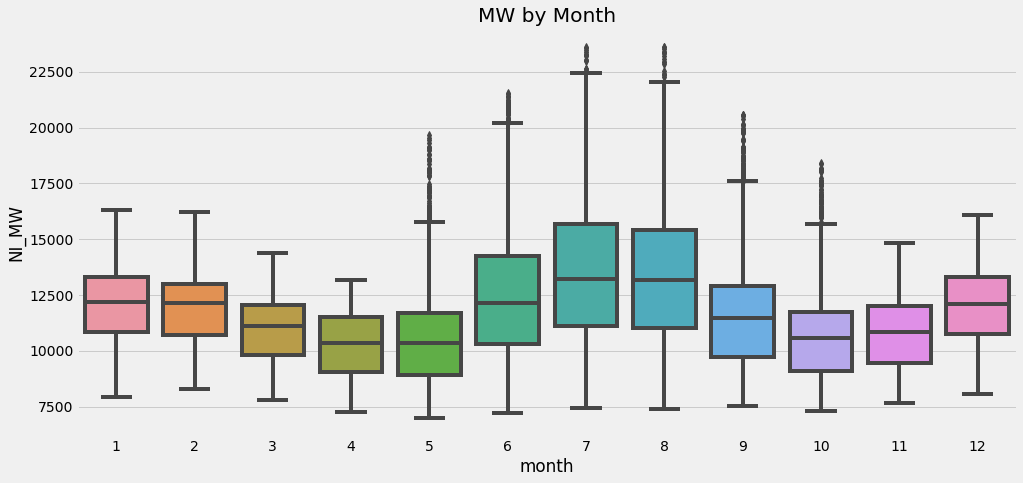

In [129]:
fig, ax = plt.subplots(figsize=(15,7))
sns.boxplot(data=df, x='month', y='NI_MW')
ax.set_title('MW by Month')

In [130]:
from sklearn.metrics import mean_squared_error

## Create a Model

In [131]:
train = create_features(train)
test = create_features(test)

In [132]:
FEATURES = ['hour', 'dayofweek', 'month', 'quarter', 'year',
       'dayofyear']
TARGET = ['NI_MW']

In [133]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [134]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [135]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

reg = XGBRegressor(objective='reg:squarederror')
grid_search = GridSearchCV(estimator=reg, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)
print(f"Best parameters found: {grid_search.best_params_}")

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best parameters found: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


In [136]:
best_params = grid_search.best_params_
best_xgb_model = XGBRegressor(**best_params, objective='reg:squarederror')

best_xgb_model.fit(X_train, y_train)

y_pred = best_xgb_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Squared Error (MSE): 1807322.1472799277
Root Mean Squared Error (RMSE): 1344.366820209398


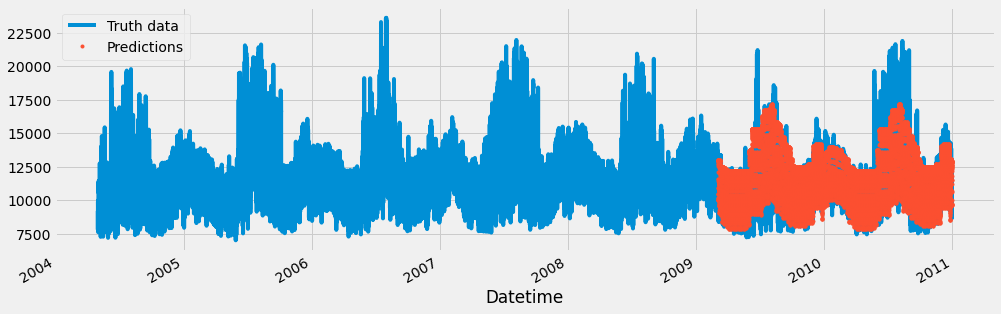

In [138]:
test['prediction'] = y_pred
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['NI_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth data', 'Predictions'])
plt.show()

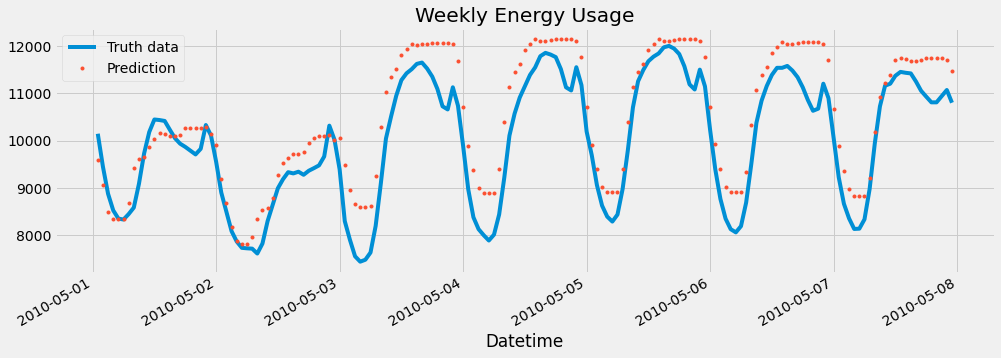

In [140]:
ax = df.loc[(df.index > '2010-05-01') & (df.index < '2010-05-08')]['NI_MW'].plot(figsize=(15,5), title='Weekly Energy Usage')
df.loc[('2010-05-01' < df.index) & ('2010-05-08' > df.index)]['prediction'].plot(style='.')
plt.legend(['Truth data', 'Prediction'])
plt.show()